https://stackoverflow.com/questions/77967527/using-script-optimise-minimize-to-fit-the-sum-of-functions-to-allow-individual-d

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
def func1(x, n, xe, ye):
    b = 1.9992 * n - 0.3271
    return ye * np.exp(-b * np.power(x / xe, 1. / n) - 1.)

In [3]:
def func2(x, y0, h):
    return y0 * np.exp(-x / h)

In [4]:
def model(x, n, xe, ye, y0, h):
    return func1(x, n, xe, ye) + func2(x, y0, h)

In [5]:
scale = 1e-11

In [6]:
p = (4.2, 11.2, 56 * scale, 0.52 * scale, 12.1)

In [7]:
np.random.seed(12345)
xexp = np.logspace(-2, np.log10(40), 50, base=10)
sigma = 1e-13
sexp = np.full(xexp.shape, sigma)
noise = sexp * np.random.normal(size=xexp.size)
yth = model(xexp, *p) 
yexp = yth + noise

In [8]:
popt, pcov = optimize.curve_fit(
    model, xexp, yexp / scale, sigma=sexp / scale, absolute_sigma=True,
    p0=(10, 10, 50, 1, 10),
    bounds=[
        (1e+0, 1e-1, 1e-1, 1e-2, 1e-1),
        (2e+1, 2e+1, 1e+2, 2e+1, 2e+1)
    ],
)
popt

array([ 4.23360076, 12.04598413, 56.49733429,  0.51167423, 11.79847404])

In [9]:
xlin = np.linspace(xexp.min(), xexp.max(), 200)
xlin = np.logspace(np.log10(xexp.min()), np.log10(xexp.max()), 200, base=10)

In [10]:
yhat = model(xlin, *popt) * scale
f1hat = func1(xlin, *popt[:3]) * scale
f2hat = func2(xlin, *popt[3:]) * scale

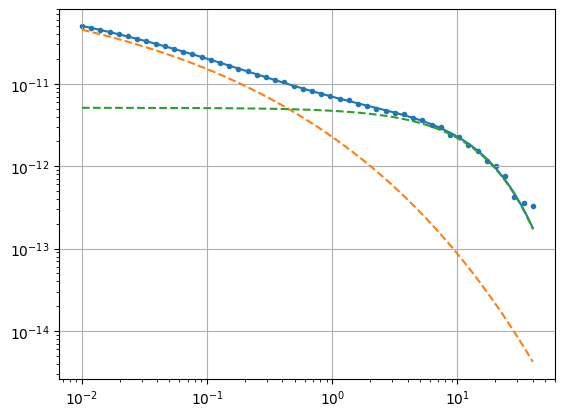

In [11]:
fig, axe = plt.subplots()
axe.scatter(xexp, yexp, marker='.')
axe.loglog(xlin, yhat)
axe.plot(xlin, f1hat, "--")
axe.plot(xlin, f2hat, "--")
axe.grid()

In [12]:
def loss_factory(x, y, s):
    def wrapped(p):
        return 0.5 * np.sum(
            np.power((y - model(x, *p)) / s, 2.)
        )
    return wrapped

In [13]:
loss = loss_factory(xexp, yexp / scale, sexp / scale)

In [14]:
sol = optimize.minimize(
    loss,
    x0=(10, 10, 50, 1, 10),
    bounds=[
        (1e+0, 2e1),
        (1e-1, 2e1),
        (1e-1, 1e2),
        (1e-1, 2e1),
        (1e-1, 2e1),
    ],
)

In [15]:
sol.x

array([ 4.23351444, 12.04435958, 56.49516374,  0.51168294, 11.79830589])

In [16]:
yhat = model(xlin, *sol.x) * scale
f1hat = func1(xlin, *sol.x[:3]) * scale
f2hat = func2(xlin, *sol.x[3:]) * scale

In [17]:
sol

      fun: 26.234799581905154
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01446452, -0.00025722, -0.0002693 ,  0.035147  ,  0.00058797])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 606
      nit: 62
     njev: 101
   status: 0
  success: True
        x: array([ 4.23351444, 12.04435958, 56.49516374,  0.51168294, 11.79830589])

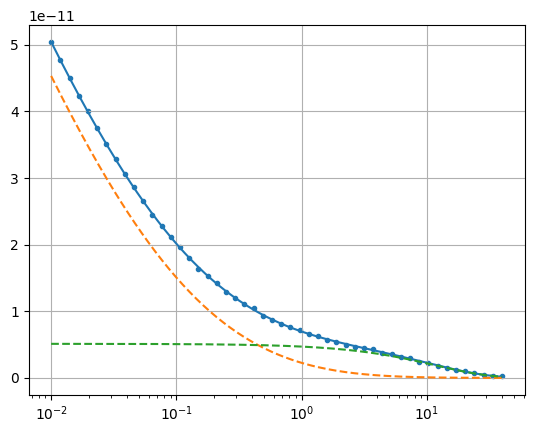

In [20]:
fig, axe = plt.subplots()
axe.scatter(xexp, yexp, marker='.')
axe.semilogx(xlin, yhat)
axe.plot(xlin, f1hat, "--")
axe.plot(xlin, f2hat, "--")
axe.grid()